# Polynomial Regression

In [1]:
# You'll need Plots for this one, so see if you have it installed 
using Pkg
Pkg.status()
Pkg.add("Plots")

Status `~/.julia/environments/v1.11/Project.toml`
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.7.0
  [60bf3e95] GLPK v1.2.1
⌃ [87dc4568] HiGHS v1.13.0
⌃ [7073ff75] IJulia v1.26.0
  [c601a237] Interact v0.10.5
⌃ [b6b21f68] Ipopt v1.7.1
⌃ [4076af6c] JuMP v1.23.6
  [86f7a689] NamedArrays v0.10.3
⌃ [91a5bcdd] Plots v1.40.9
  [fdbf4ff8] XLSX v0.10.4
Info Packages marked with ⌃ have new versions available and may be upgradable.


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [2]:
# define (x,y) coordinates of the points
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ]
y = [ 1, 3, 0, 1, 2, 4, 6, 7, 5, 5, 6, 7.2, 5.5,  4, 3.2, 5]
;


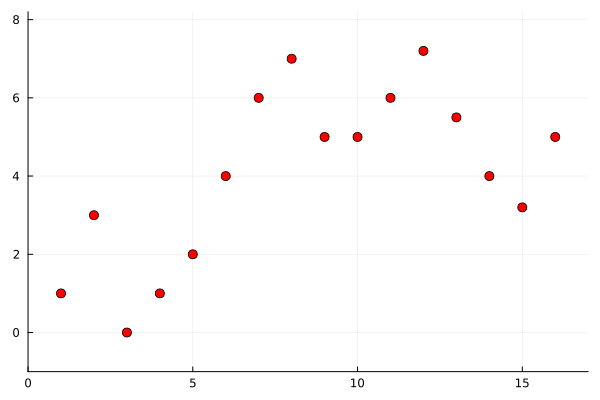

In [3]:
using Plots
function plotxypoints(x, y)
    minx, maxx = minimum(x), maximum(x)
    miny, maxy = minimum(y), maximum(y)

    plot(x, y, seriestype=:scatter, color=:red, markersize=5, legend=false)
    xlims!(minx - 1, maxx + 1)
    ylims!(miny - 1, maxy + 1)
end
;
plotxypoints(x,y)

In [4]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 4

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
A

16×5 Matrix{Float64}:
     1.0     1.0    1.0   1.0  1.0
    16.0     8.0    4.0   2.0  1.0
    81.0    27.0    9.0   3.0  1.0
   256.0    64.0   16.0   4.0  1.0
   625.0   125.0   25.0   5.0  1.0
  1296.0   216.0   36.0   6.0  1.0
  2401.0   343.0   49.0   7.0  1.0
  4096.0   512.0   64.0   8.0  1.0
  6561.0   729.0   81.0   9.0  1.0
 10000.0  1000.0  100.0  10.0  1.0
 14641.0  1331.0  121.0  11.0  1.0
 20736.0  1728.0  144.0  12.0  1.0
 28561.0  2197.0  169.0  13.0  1.0
 38416.0  2744.0  196.0  14.0  1.0
 50625.0  3375.0  225.0  15.0  1.0
 65536.0  4096.0  256.0  16.0  1.0

In [17]:
# Solve the LEAST SQUARES polynomial fit

using JuMP, HiGHS, LinearAlgebra
m = Model(HiGHS.Optimizer)

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
# @objective(m, Min, dot(y-A*u,y-A*u) )

optimize!(m)
uopt = value.(u)
println(termination_status(m))
println("The objective value is ", objective_value(m))
println(uopt)

# Let's check Julia LinearAlgebra (probably more numerically stable and faster)
api = pinv(A)
u2 = pinv(A)*y 
println(u2)

# And can even do fancy \ operator 
u3 = A \ y 
println(u3)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Cost   [1e+02, 2e+06]
  Bound  [0e+00, 0e+00]
  Iteration        Objective     NullspaceDim
Model status        : Optimal
Objective value     :  1.7164392266e+01
HiGHS run time      :          0.00
OPTIMAL
The objective value is 17.164392265967592
[0.002320864627149438, -0.08461677370470894, 0.969731801264976, -3.3515873180339115, 4.320671824083403]
[0.0023208650869255385, -0.08461679037337214, 0.969732004643997, -3.3515882584479426, 4.320673076923315]
[0.002320865086925542, -0.08461679037337225, 0.9697320046439984, -3.351588258447946, 4.320673076923319]


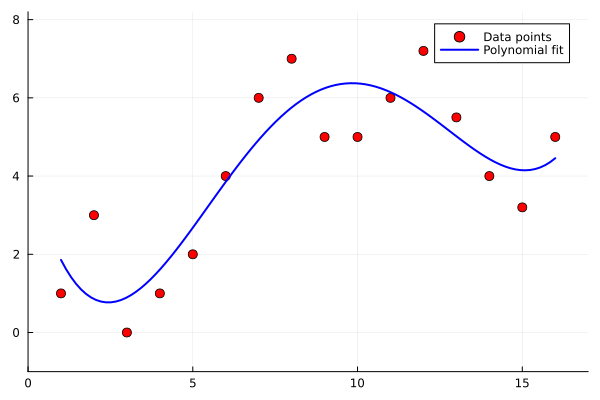

In [6]:

function plotwregsol(x, y, usol, k)
    minx, maxx = minimum(x), maximum(x)
    miny, maxy = minimum(y), maximum(y)

    # Generate fine grid points for plotting the polynomial fit
    npts = 100
    xfine = range(minx, stop=maxx, length=npts)
    ffine = ones(npts)

    # Construct the polynomial feature matrix
    #  This will have rows like [x^4, x^3, x^2, x^1, 1] for the different values in xfine 
    for j = 1:k
        ffine = [ffine .* xfine ones(npts)]
    end

    # Compute the fitted curve values
    yfine = ffine * usol

    # Plot points and the fitted curve
    scatter(x, y, color=:red, markersize=5, label="Data points")
    plot!(xfine, yfine, color=:blue, linewidth=2, label="Polynomial fit")

    # Adjust axis limits
    xlims!(minx - 1, maxx + 1)
    ylims!(miny - 1, maxy + 1)

end

plotwregsol(x,y,uopt,k)

In [7]:
# Solve the L_1 NORM polynomial fit. 
#  We learned how to do this already
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)
set_silent(m)

@variable(m, u[1:k+1])
@variable(m, t[1:n])
@constraint(m, y-A*u .<= t)
@constraint(m, A*u-y .<= t)
@objective(m, Min, sum(t))

optimize!(m)
uopt_l1 = value.(u)
println(termination_status(m))
println(objective_value(m))
println(uopt_l1)

OPTIMAL
12.167132867132857
[0.0033022533022532973, -0.11600621600621584, 1.2794483294483279, -4.2418026418026376, 4.0750582750582725]


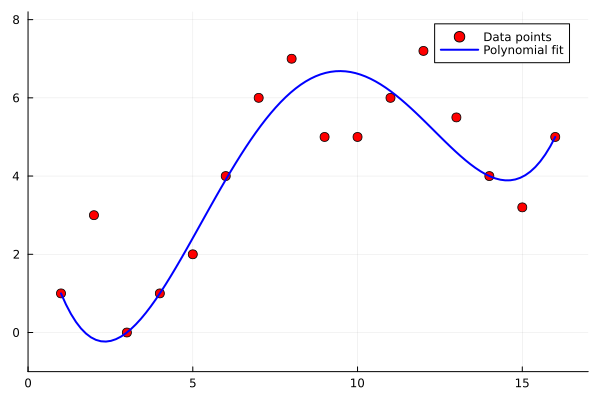

In [8]:
plotwregsol(x,y,uopt_l1,k)

In [23]:
# Let's also do infinity norm 

m = Model(HiGHS.Optimizer)
set_silent(m)

@variable(m, u[1:k+1])
@variable(m, z)
@constraint(m, y-A*u .<= z*ones(n))
@constraint(m, A*u-y .<= z*ones(n))
@objective(m, Min, z)

optimize!(m)
uopt_linfinity = value.(u)
println(termination_status(m))
println(objective_value(m))
println(uopt_linfinity)

OPTIMAL
1.458156028368797
[0.0014302600472813878, -0.058058088483622206, 0.728904086457293, -2.718071597433339, 4.503951367781184]


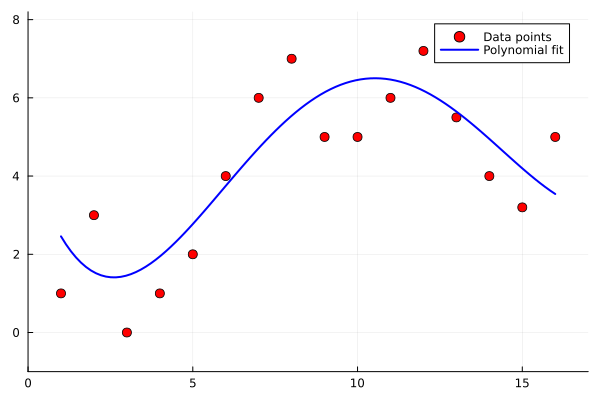

In [10]:
plotwregsol(x,y,uopt_linfinity,k)